# LIMEを用いたirisデータの分類

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## データセットの取得

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
print("データセット内容の種類")
print(iris.keys())
print("特徴量の種類")
print(iris['feature_names'])
print("ラベルの種類")
print(iris.target_names)
print("shape")
print(iris['data'].shape)

データセット内容の種類
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
特徴量の種類
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
ラベルの種類
['setosa' 'versicolor' 'virginica']
shape
(150, 4)


In [3]:
X = iris.data
y = iris.target

iris_dataframe = pd.DataFrame(X, columns=iris.feature_names)
iris_dataframe.head(5)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

array([[<AxesSubplot:xlabel='sepal length (cm)', ylabel='sepal length (cm)'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='sepal length (cm)'>,
        <AxesSubplot:xlabel='petal length (cm)', ylabel='sepal length (cm)'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='sepal length (cm)'>],
       [<AxesSubplot:xlabel='sepal length (cm)', ylabel='sepal width (cm)'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='sepal width (cm)'>,
        <AxesSubplot:xlabel='petal length (cm)', ylabel='sepal width (cm)'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='sepal width (cm)'>],
       [<AxesSubplot:xlabel='sepal length (cm)', ylabel='petal length (cm)'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='petal length (cm)'>,
        <AxesSubplot:xlabel='petal length (cm)', ylabel='petal length (cm)'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='petal length (cm)'>],
       [<AxesSubplot:xlabel='sepal length (cm)', ylabel='petal width (c

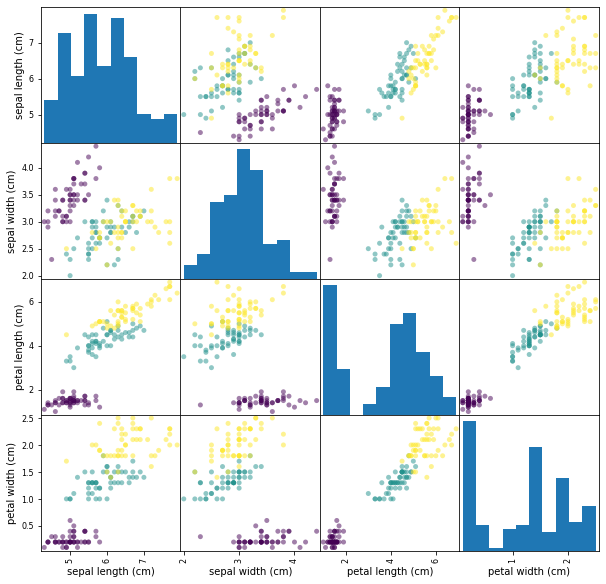

In [4]:
pd.plotting.scatter_matrix(iris_dataframe, c=y, figsize=(10, 10), s=100)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (120, 4)
X_test.shape :  (30, 4)
y_train.shape :  (120,)
y_test.shape :  (30,)


-----
## 学習と評価

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = sklearn.ensemble.RandomForestClassifier(n_estimators=2, max_depth = 3, random_state=2)
model.fit(X_train, y_train)

accuracy_score(y_test, model.predict(X_test))

0.9666666666666667

----
## LIMEによるモデルの可視化

In [7]:
from lime.lime_tabular import LimeTabularExplainer

feature_names = iris['feature_names']
class_names = iris.target_names

explainer = LimeTabularExplainer(training_data=X_train,
                                 mode="classification",
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 random_state=1)

In [8]:
i = 0
pd.DataFrame([X_test[i]], columns=iris.feature_names)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                6.1               2.8                4.7               1.2

LIMEを使用することでモデルの可視化を行うことができる。

各特徴量の値がどのようになっていることが分類に貢献しているかを確認することが可能。

しかし、LIMEはモデルの一部を線形モデルで近似しているため、線形の関係のみ可視化することができる。

In [9]:
#推定結果を通知する関数が必要
#predict_probaは入力データが1層の配列には対応していないため、オリジナルの関数を用意する
def predict_fn(X):
    if len(X.shape) == 1:
        return model.predict_proba(X.reshape(1, -1))[0]
    else:
        return model.predict_proba(X)

np.random.seed(1)
exp = explainer.explain_instance(data_row=X_test[i],#入力データは1つのみ
                                 predict_fn=predict_fn)
exp.show_in_notebook()

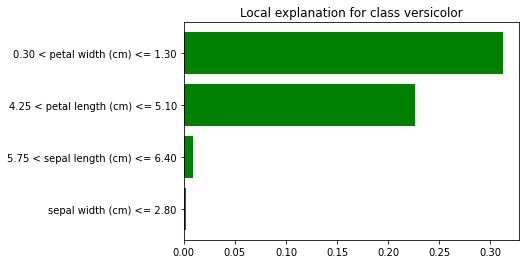

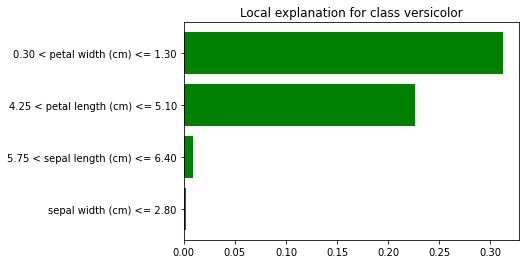

In [10]:
exp.as_pyplot_figure()

In [11]:
exp.as_list()

[('0.30 < petal width (cm) <= 1.30', 0.3121542290975754),
 ('4.25 < petal length (cm) <= 5.10', 0.22622404656829564),
 ('5.75 < sepal length (cm) <= 6.40', 0.008834596965866423),
 ('sepal width (cm) <= 2.80', 0.0016803855533080822)]

---
## LIMEの可視化結果と学習データを統計結果の比較

LIMEの出力結果の確からしさの確認を行う。

学習データの統計的なデータでLIMEの出力結果が正しいかどうかを大まかに確認する。

学習データの各特徴量のばらつきなどからLIMEの結果が妥当であることがわかる

In [12]:
X_train_dataframe = pd.DataFrame(X_train, columns=iris.feature_names)

y_label = []
for i in y_train:
    y_label.append(iris.target_names[i])
y_train_dataframe = pd.DataFrame(y_label, columns=['result'])

train_dataframe = pd.concat([X_train_dataframe, y_train_dataframe], axis=1)

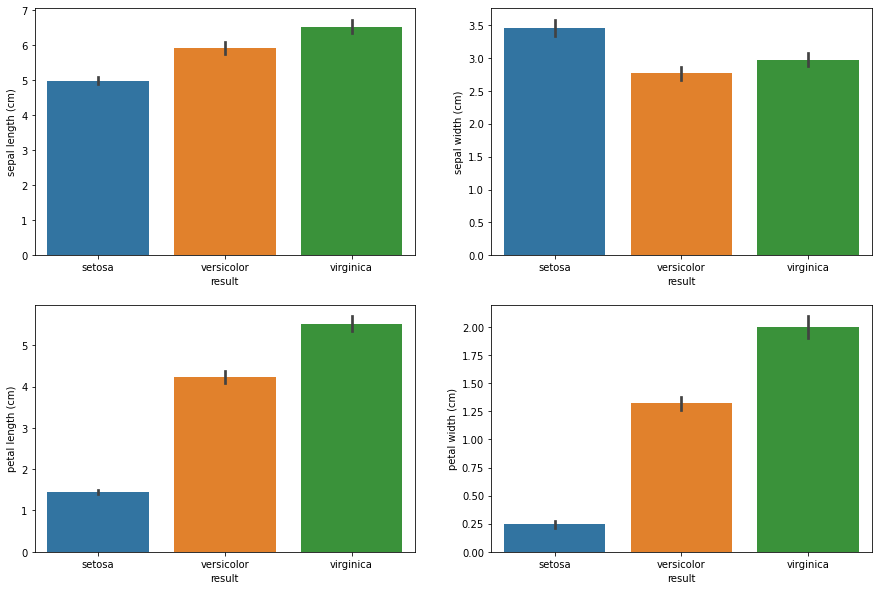

In [13]:
import seaborn as sns

fig = plt.figure(figsize=[15,10])
for i, f in enumerate(iris['feature_names']):
    fig.add_subplot(2, 2, i+1)
    sns.barplot(y=f, x='result', data= train_dataframe)

---
## LIMEのパラメータ調整
LIMEによるモデルの可視化はパラメータによって変化する

### kernel_width
LIMEでのランダムなダミーデータの重みづけパラメータ

値を小さくするとより局所的な可視化が行え、大きくすると大局的な可視化を行う

### kernel_width=0.1の場合

In [14]:
explainer = LimeTabularExplainer(training_data=X_train,
                                 mode="classification",
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 kernel_width=0.1,
                                 random_state=1)

i= 2
exp = explainer.explain_instance(data_row=X_test[i],#入力データは1つのみ
                                 predict_fn=predict_fn)
exp.show_in_notebook()

### kernel_width=1の場合

In [15]:
explainer = LimeTabularExplainer(training_data=X_train,
                                 mode="classification",
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 kernel_width=1,
                                 random_state=1)

exp = explainer.explain_instance(data_row=X_test[i],#入力データは1つのみ
                                 predict_fn=predict_fn)
exp.show_in_notebook()

### kernel_width=10の場合

In [16]:
explainer = LimeTabularExplainer(training_data=X_train,
                                 mode="classification",
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 kernel_width=10,
                                 random_state=1)

exp = explainer.explain_instance(data_row=X_test[i],#入力データは1つのみ
                                 predict_fn=predict_fn)
exp.show_in_notebook()